In [7]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
TIME_STEP = 1/100

In [269]:
class Model:
    
    def __init__(self, noise_scale=0, noise_decay=0, noise_momentum=0.5):
        self.__x = 0
        self.__y = 0
        self.__z = 0
        self.__vx = 0
        self.__vy = 0
        self.__vz = 0
        self.__noise_scale = noise_scale
        self.__noise_decay = noise_decay
        self.__noise_momentum = noise_momentum
        self.noise = np.zeros(3)
    
    def step(self, ax, ay, az):
        noise = np.random.randn(3) * self.__noise_scale
        self.noise = \
            self.__noise_momentum*self.noise + \
            (1-self.__noise_momentum)*noise
        self.noise *= 1-self.__noise_decay
        self.__x += self.__vx*TIME_STEP + 0.5*ax*TIME_STEP*TIME_STEP
        self.__y += self.__vy*TIME_STEP + 0.5*ay*TIME_STEP*TIME_STEP
        self.__z += self.__vz*TIME_STEP + 0.5*az*TIME_STEP*TIME_STEP
        self.__vx += ax*TIME_STEP + self.noise[0]
        self.__vy += ay*TIME_STEP + self.noise[1]
        self.__vz += az*TIME_STEP + self.noise[2]
        return self.__x, self.__y, self.__z

In [270]:
class PIDController:
    
    def __init__(self, Kp, Ki, Kd):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.disable_integral = False
        self.ierr = 0
        self.__prev_err = 0
    
    def step(self, measured, desired):
        err = desired - measured
        self.ierr = 0 if self.disable_integral else self.ierr + err*TIME_STEP
        derr = (err-self.__prev_err)/TIME_STEP
        self.__prev_err = err
        return self.Kp*err + self.Ki*self.ierr + self.Kd*derr

final noise -0.003984734948857865 -0.01825477992231255 0.0006655285091466433
final ierr -0.3907501517650069 -0.14358026772129887 0.11357438852514978
final err -0.011681444275564348 0.05973704905819721 -0.024254113510166875


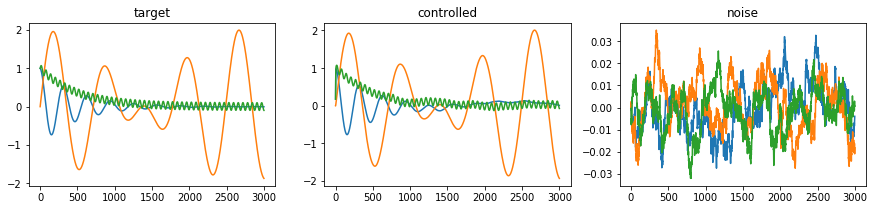

In [282]:
Kp,Ki,Kd = 10,1,35
model = Model(noise_scale=0.15, noise_decay=0, noise_momentum=0.99)
pid_x = PIDController(Kp,Ki,Kd)
pid_y = PIDController(Kp,Ki,Kd)
pid_z = PIDController(Kp,Ki,Kd)
x,y,z = model.step(0,0,0)
target = lambda t: (
    np.cos(t/50)*np.exp(-t/500),
    np.sin(t/100)+np.sin(t/130),
    np.exp(-t/500)+np.sin(t/10)*0.1)
T = []
Y = []
N = []
for t in range(3000):
    tx,ty,tz = target(t)
    cx = pid_x.step(x,tx)
    cy = pid_y.step(y,ty)
    cz = pid_z.step(z,tz)
    x,y,z = model.step(cx,cy,cz)
    T.append((tx,ty,tz))
    Y.append((x,y,z))
    N.append(model.noise)
print('final noise', *model.noise)
print('final ierr', pid_x.ierr, pid_y.ierr, pid_z.ierr)
print('final err', tx-x, ty-y, tz-z)
plt.figure(figsize=(15,3))
plt.subplot(131)
plt.title('target')
plt.plot(T)
plt.subplot(132)
plt.title('controlled')
plt.plot(Y)
plt.subplot(133)
plt.title('noise')
plt.plot(N)
plt.show()